In [18]:
import pandas as pd

Cargo un archivo csv, creado a partir de los accesos al servidor de apache de SEDICI, correspondientes a un día entero. 

In [19]:
df = pd.read_parquet('data/df_log.parquet.gzip')
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype                    
---  ------          --------------  -----                    
 0   ip              50000 non-null  string                   
 1   time            50000 non-null  datetime64[ns, UTC-03:00]
 2   request         50000 non-null  string                   
 3   status          50000 non-null  Int64                    
 4   size            50000 non-null  Int64                    
 5   Referer         8759 non-null   string                   
 6   User_agent      49949 non-null  string                   
 7   spambot         50000 non-null  boolean                  
 8   has_Referer     50000 non-null  boolean                  
 9   has_User_agent  50000 non-null  boolean                  
dtypes: Int64(2), boolean(3), datetime64[ns, UTC-03:00](1), string(4)
memory usage: 3.1 MB


Reemplazo valores nulos en User_agent con el texto 'NOTSET'

In [20]:
df['User_agent'] = df['User_agent'].fillna(value='NULL')
df['Referer'] = df['Referer'].fillna(value='NULL')

In [21]:
df.head(5)

,ip,time,request,status,size,Referer,User_agent,spambot,has_Referer,has_User_agent
0,3.224.220.101,2022-03-31 00:00:13-03:00,GET /handle/10915/60216/browse?authority=http%...,200,7165,NULL,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,True,False,True
1,173.252.107.9,2022-03-31 00:00:13-03:00,GET /handle/10915/45833 HTTP/1.1,200,9539,NULL,facebookexternalhit/1.1 (+http://www.facebook....,True,False,True
2,173.252.107.3,2022-03-31 00:00:13-03:00,GET /handle/10915/31292 HTTP/1.1,200,9512,NULL,facebookexternalhit/1.1 (+http://www.facebook....,True,False,True
3,173.252.107.22,2022-03-31 00:00:14-03:00,GET /handle/10915/66507 HTTP/1.1,200,10170,NULL,facebookexternalhit/1.1 (+http://www.facebook....,True,False,True
4,173.252.107.9,2022-03-31 00:00:14-03:00,GET /handle/10915/66507 HTTP/1.1,200,10170,NULL,facebookexternalhit/1.1 (+http://www.facebook....,True,False,True


La idea es aplicar K-Means a partir de la cantidad de requests que hace una IP junto con el tamaño en bytes descargado en un día. Para se va a agrupar cada acceso del log por IP y se agregar una columna para la cantidad de requests en un día junto con la cantidad de bytes descargados

In [22]:
df_groupby_ip = df.groupby(['ip','spambot'], as_index=False).size().rename(columns={'size':'count'}) # agrupo por ip y agrego un columna count con la cantidad de requests hechas 
df_groupby_ip['size'] = df.groupby(['ip','spambot'], as_index=False)['size'].sum()['size'] # agrego a df_groupby_ip una columna con la cantidad de bytes descargados en un día
df_groupby_ip = df_groupby_ip.sort_values(by=['count', 'size', 'spambot'], ascending=False)
df_groupby_ip

,ip,spambot,count,size
5474,66.249.70.123,True,9507,1132274910
4864,3.224.220.101,True,4045,38194228
5187,52.70.240.171,True,3951,36939373
4844,23.22.35.162,True,3922,39935846
4217,199.47.82.18,False,2074,2059151156
...,...,...,...,...
1712,186.128.84.205,False,1,241
4343,200.68.137.161,False,1,241
430,17.121.112.1,True,1,164
452,17.121.113.120,True,1,164


Escalo datos para poder procesarlos con KMeans

In [23]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler = MinMaxScaler().fit(df_groupby_ip[['count','size','spambot']].values)

In [25]:
df_cluster = pd.DataFrame(scaler.transform(df_groupby_ip[['count','size','spambot']].values), columns=["cantidad", "tamaño",'spambot'])

In [26]:
df_cluster['spambot'] = df_cluster['spambot'].astype(int)
df_cluster.dtypes

cantidad    float64
tamaño      float64
spambot       int64
dtype: object

In [27]:
df_cluster.head(5)

,cantidad,tamaño,spambot
0,1.000000,0.549875,1
1,0.425416,0.018548,1
2,0.415527,0.017939,1
3,0.412476,0.019394,1
4,0.218073,1.000000,0


## KMeans

In [28]:
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans

In [29]:
db_indexes = {}
for n in range(2,10):
    kmeans = KMeans(n).fit(df_cluster.values)
    db_index = davies_bouldin_score(df_cluster.values, kmeans.labels_)
    db_indexes.update({n: db_index})

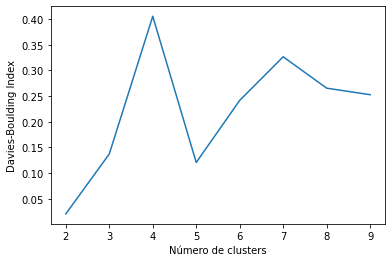

In [30]:
plt.plot(list(db_indexes.keys()), list(db_indexes.values()))
plt.xlabel("Número de clusters")
plt.ylabel("Davies-Boulding Index")
plt.show()

Nos quedamos con 3 como la cantidad de clusters a usar debido a que su índice de David Boulding es el menor

In [31]:
n_clusters = 5
kmeans = KMeans(n_clusters).fit(df_cluster.values)
df_cluster["cluster"] = kmeans.labels_
df_groupby_ip ["cluster"] = df_cluster["cluster"]
df_groupby_ip


,ip,spambot,count,size,cluster
5474,66.249.70.123,True,9507,1132274910,1
4864,3.224.220.101,True,4045,38194228,1
5187,52.70.240.171,True,3951,36939373,1
4844,23.22.35.162,True,3922,39935846,1
4217,199.47.82.18,False,2074,2059151156,1
...,...,...,...,...,...
1712,186.128.84.205,False,1,241,1
4343,200.68.137.161,False,1,241,1
430,17.121.112.1,True,1,164,1
452,17.121.113.120,True,1,164,1


Dibujo

In [32]:
from random import randint
colores = []
for i in range(n_clusters):
    colores.append('#%06X' % randint(0, 0xFFFFFF))

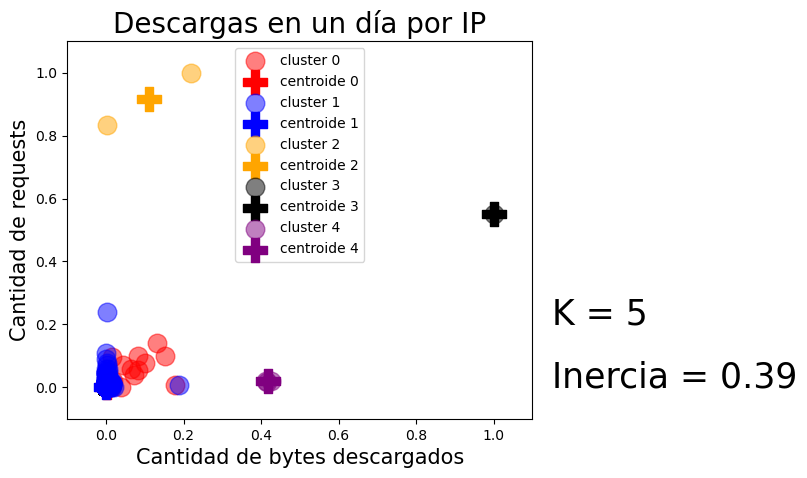

In [33]:
plt.figure(figsize=(6, 5), dpi=100)

colores = ["red", "blue", "orange", "black", "purple", "pink", "brown"]
for cluster in range(kmeans.n_clusters):
    plt.scatter(df_cluster[df_cluster["cluster"] == cluster]["cantidad"],
                df_cluster[df_cluster["cluster"] == cluster]["tamaño"],
                marker="o", s=180, color=colores[cluster], alpha=0.5, label='cluster ' + str(cluster))
    
    plt.scatter(kmeans.cluster_centers_[cluster][0], 
                kmeans.cluster_centers_[cluster][1], 
                marker="P", s=280, color=colores[cluster], label='centroide ' + str(cluster) )

plt.legend()

plt.title("Descargas en un día por IP", fontsize=20)
plt.xlabel("Cantidad de bytes descargados", fontsize=15)
plt.ylabel("Cantidad de requests", fontsize=15)
plt.text(1.15, 0.2, "K = %i" % kmeans.n_clusters, fontsize=25)
plt.text(1.15, 0, "Inercia = %0.2f" % kmeans.inertia_, fontsize=25)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)    
plt.show()

In [34]:
kmeans.cluster_centers_

array([[ 2.82726588e-03,  2.22778869e-03,  1.00000000e+00],
       [ 2.11788618e-04,  1.14070113e-03, -7.35522754e-16],
       [ 1.10666947e-01,  9.16881447e-01,  0.00000000e+00],
       [ 1.00000000e+00,  5.49874560e-01,  1.00000000e+00],
       [ 4.17806298e-01,  1.86272490e-02,  1.00000000e+00]])

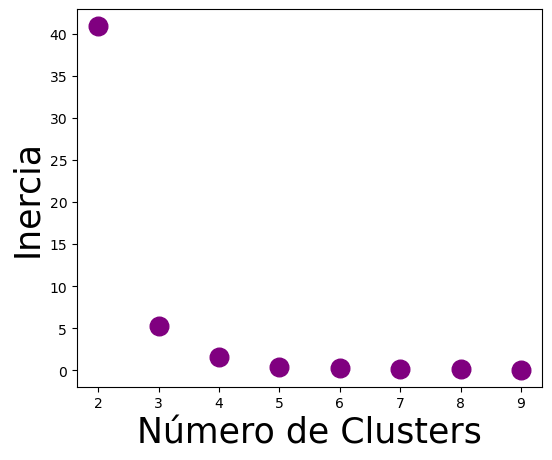

In [35]:
inercias = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(df_cluster.values)
    inercias.append(kmeans.inertia_)

plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(range(2, 10), inercias, marker="o", s=180, color="purple")
plt.xlabel("Número de Clusters", fontsize=25)
plt.ylabel("Inercia", fontsize=25)
plt.show()

In [36]:
df_log = pd.merge(df, df_groupby_ip[['ip', 'cluster']], on=['ip'])


In [37]:
df_log[(df_log['cluster'] == 1) & (df_log['spambot'] == False)].head(5)

,ip,time,request,status,size,Referer,User_agent,spambot,has_Referer,has_User_agent,cluster
8618,190.152.191.255,2022-03-31 00:00:17-03:00,GET /bitstream/handle/10915/1965/Conclusiones....,200,240239,http://www.google.com/,Mozilla/5.0 (Linux; Android 10; SM-A105M) Appl...,False,True,True,1
8619,191.100.238.243,2022-03-31 00:00:17-03:00,GET /handle/10915/21 HTTP/1.1,200,8058,https://www.google.com/,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,False,True,True,1
8620,191.100.238.243,2022-03-31 00:00:18-03:00,GET /bitstream/id/4623/?sequence=-1 HTTP/1.1,200,12178,http://sedici.unlp.edu.ar/handle/10915/21,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,False,True,True,1
8621,191.100.238.243,2022-03-31 00:00:35-03:00,GET /handle/10915/21/discover?filter=Educaci%C...,200,7846,http://sedici.unlp.edu.ar/handle/10915/21,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,False,True,True,1
8622,193.235.141.134,2022-03-31 00:00:17-03:00,GET /discover?current-scope=&filter_0=Revista+...,200,8475,NULL,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,False,False,True,1


In [50]:
for i in range(n_clusters):
    print("cantidad de registros en cluster {}: ".format(i)  + str(len(df_groupby_ip[df_groupby_ip['cluster'] == i])))


cantidad de registros en cluster 0: 379
cantidad de registros en cluster 1: 5278
cantidad de registros en cluster 2: 2
cantidad de registros en cluster 3: 1
cantidad de registros en cluster 4: 3


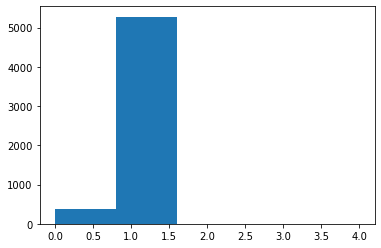

In [43]:
plt.hist(df_groupby_ip['cluster'], bins=5)
plt.show()

In [40]:
df_groupby_ip[df_groupby_ip['cluster'] == 0]

,ip,spambot,count,size,cluster
5475,66.249.70.125,True,1252,290675506,0
5476,66.249.70.127,True,418,143608171,0
5477,66.249.70.98,True,163,39971344,0
5145,5.161.86.222,False,142,23509261,0
5138,5.161.86.142,False,141,32850360,0
...,...,...,...,...,...
5204,54.159.215.122,False,1,2016,0
5478,66.249.72.250,True,1,613,0
5479,66.249.72.252,True,1,613,0
955,179.53.198.139,False,1,391,0


A continuación se utilizará la técnica de Arbol de clasificación para explicar que criterios se usaron para el clustering

In [41]:
from sklearn.model_selection import train_test_split

datos_entrena, datos_prueba, clase_entrena, clase_prueba = train_test_split(
    df_groupby_ip[["count", "size", "spambot"]],
    df_groupby_ip["cluster"], 
    test_size=0.30)


0.8940553266627428
|--- spambot <= 0.50
|   |--- cantidad <= 107.00
|   |   |--- tamaño <= 11167.50
|   |   |   |--- tamaño <= 11134.00
|   |   |   |   |--- tamaño <= 8447.00
|   |   |   |   |   |--- tamaño <= 8406.00
|   |   |   |   |   |   |--- tamaño <= 7349.00
|   |   |   |   |   |   |   |--- tamaño <= 7091.50
|   |   |   |   |   |   |   |   |--- tamaño <= 360.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- tamaño >  360.50
|   |   |   |   |   |   |   |   |   |--- tamaño <= 370.00
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- tamaño >  370.00
|   |   |   |   |   |   |   |   |   |   |--- tamaño <= 1291.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- tamaño >  1291.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |--- tamaño >  7091.50
|   |   |   |   |   |   |   |   |--- class:

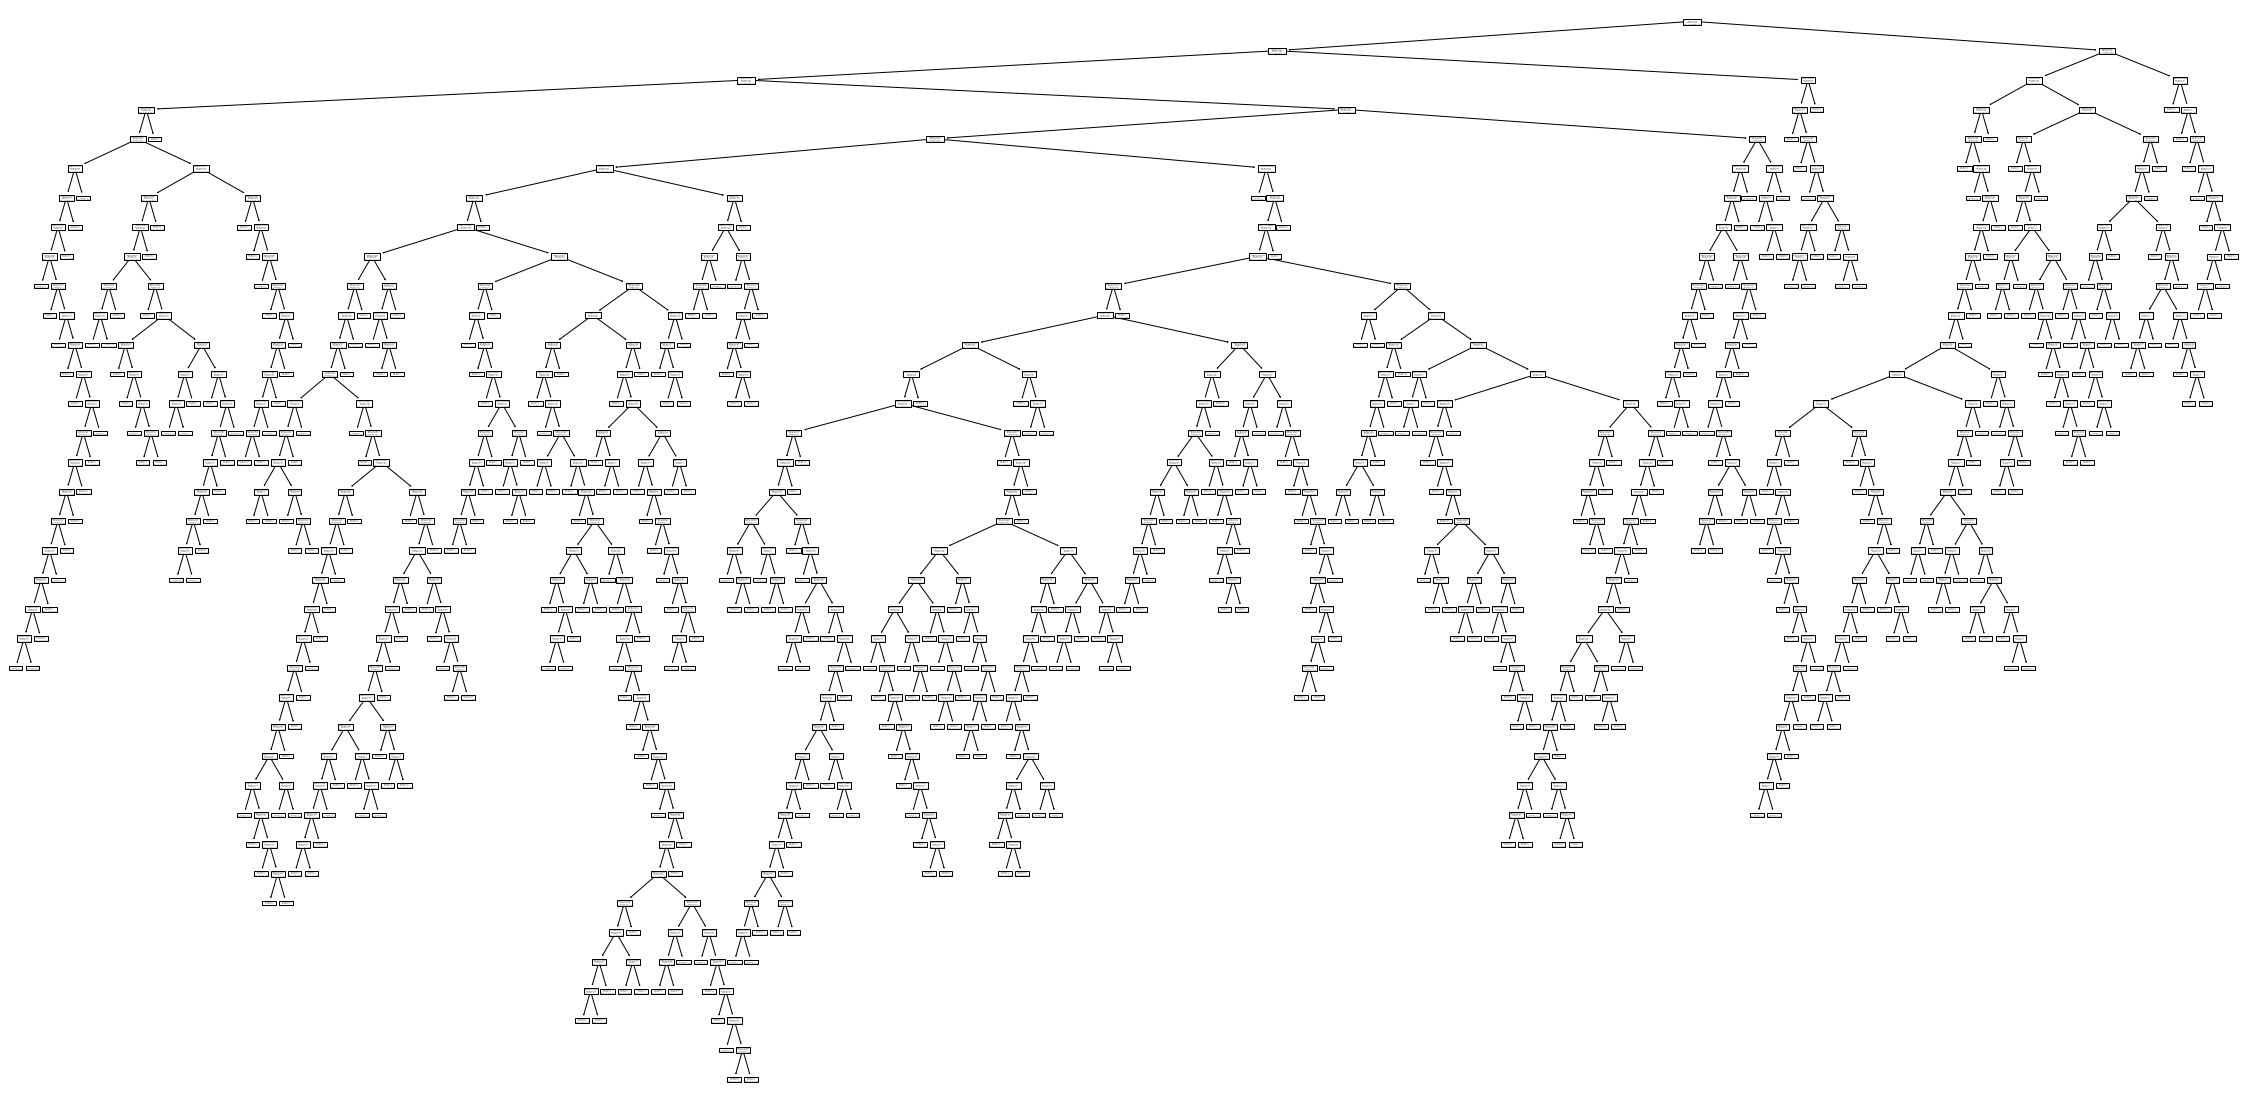

In [42]:
from sklearn import tree

arbol_decision = tree.DecisionTreeClassifier(criterion="entropy")

arbol = arbol_decision.fit(datos_entrena, clase_entrena)

accuracy = arbol_decision.score(datos_prueba, clase_prueba)

print(accuracy)

print(tree.export_text(arbol, feature_names=["cantidad", "tamaño", "spambot"]))
plt.figure(figsize=(40, 20))
tree.plot_tree(arbol, feature_names=["cantidad", "tamaño", "spambot"])
plt.show()

